In [1]:
import pandas as pd
import numpy as np
import os
from google.colab import drive 

import matplotlib.pyplot as plt
import seaborn as sns

import librosa
import librosa.display
# to play the audio files
from IPython.display import Audio

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, TimeDistributed
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten, LSTM,Bidirectional,TimeDistributed
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint




In [ ]:
drive.mount('/content/drive')
data_path = '/content/drive/My Drive/empathic_data/data/audio-files/'

Mounted at /content/drive


In [ ]:
filepath = []
file_name = []
total = [] 
for filename in os.listdir(data_path):
    if filename.endswith(".wav"): 
      file_name.append(filename)
      filepath.append(data_path)

In [ ]:
merged_path = [''.join(x) for x in zip(filepath, file_name)]

In [ ]:
dictionary = dict(zip(file_name, merged_path))

In [ ]:
df = pd.read_csv('/content/merged_data.csv')
df['path'] = df['file_name'].map(dictionary)
df['Emotion'] = df['Emotion'].str.capitalize()
df = df[df['Emotion'] != 'Pleasure']
df['Emotion'].replace('Pain', 'Sad', inplace=True)
df['Emotion'].replace('Achievement', 'Happy', inplace=True)
df.head()

,file_name,Speaker,Emotion,Intensity,Dataframe,Duration,Word,Type,Gender,path
0,S04_fear_peak_03.wav,S04,Fear,peak,VIVAE,0.752472,NaN,Sound,NaN,/content/drive/My Drive/empathic_data/data/aud...
3,S04_pain_strong_08.wav,S04,Sad,strong,VIVAE,0.752472,NaN,Sound,NaN,/content/drive/My Drive/empathic_data/data/aud...
4,S04_fear_strong_05.wav,S04,Fear,strong,VIVAE,0.672404,NaN,Sound,NaN,/content/drive/My Drive/empathic_data/data/aud...
5,S08_pain_peak_01.wav,S08,Sad,peak,VIVAE,0.536463,NaN,Sound,NaN,/content/drive/My Drive/empathic_data/data/aud...
6,S06_fear_moderate_03.wav,S06,Fear,moderate,VIVAE,0.752472,NaN,Sound,NaN,/content/drive/My Drive/empathic_data/data/aud...


In [ ]:
print("number of files is {}".format(len(df)))

number of files is 4640


In [ ]:
df.Emotion.replace('Ps','Surprise',inplace=True)

In [ ]:
df.Emotion.unique()

array(['Fear', 'Sad', 'Surprise', 'Angry', 'Happy', 'Calm', 'Disgust'],
      dtype=object)

<Figure size 432x288 with 0 Axes>

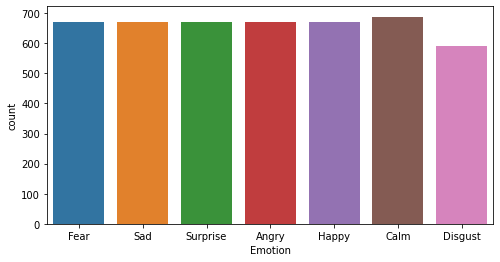

In [ ]:
fig = plt.figure()
plt.figure(figsize=(8, 4))
sns.countplot(x="Emotion", data=df)
plt.show();

In [ ]:
def features_extractor(file,inputfeature):
  if inputfeature == 'mfcc':
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    return np.mean(mfccs_features.T,axis=0)

  if inputfeature == 'mel':
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    mel = np.mean(librosa.feature.melspectrogram(y=audio, sr=sample_rate).T, axis=0)
    return mel
    #result = np.hstack((result, mel)) # stacking horizontally
    

In [ ]:
from tqdm import tqdm
### Now we iterate through every audio file and extract features 
### using Mel-Frequency Cepstral Coefficients

extracted_features=[]
for index_num,row in tqdm(df.iterrows()):
    file_name = row["path"]
    final_class_labels=row["Emotion"]
    data=features_extractor(file_name,'mfcc')
    extracted_features.append([data,final_class_labels])
  

In [ ]:
### converting extracted_features to Pandas dataframe
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.head()

,feature,class
0,"[-388.54413, -21.13698, -122.90878, -28.14519,...",Fear
1,"[-484.03323, 54.406715, -46.810455, -2.0012827...",Sad
2,"[-352.4352, 28.341053, -80.77427, -22.387562, ...",Fear
3,"[-334.71112, 4.223718, -143.99582, -11.064583,...",Sad
4,"[-455.17175, 64.60318, -26.945173, -13.53749, ...",Fear


In [ ]:
import json
data = json.load(open('/content/mfcc.json'))
df = pd.DataFrame(data)

In [ ]:
df

,feature,class
0,"[-388.544128418, -21.1369800568, -122.90878295...",Fear
1,"[-484.0332336426, 54.4067153931, -46.810455322...",Sad
2,"[-352.4352111816, 28.341053009, -80.774269104,...",Fear
3,"[-334.7111206055, 4.2237181664, -143.995819091...",Sad
4,"[-455.1717529297, 64.6031799316, -26.945173263...",Fear
...,...,...
4635,"[-529.6136474609, 58.8643531799, -9.316198349,...",Fear
4636,"[-335.4749755859, 55.7228393555, -29.179220199...",Fear
4637,"[-512.0512084961, 62.8047599792, -19.674118042...",Disgust
4638,"[-520.8950195312, 77.6130599976, -10.199032783...",Disgust


In [ ]:
### Split the dataset into independent and dependent dataset
X=np.array(df['feature'].tolist())
y=np.array(df['class'].tolist())

In [ ]:
### Label Encoding
###y=np.array(pd.get_dummies(y))
### Label Encoder
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [ ]:
### Train Test Split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3712, 40), (928, 40), (3712, 7), (928, 7))

In [ ]:
X_train = np.expand_dims(X_train, axis=2)
X_train = np.swapaxes(X_train, 1, 2)
X_train = np.expand_dims(X_train, axis=2)

X_test = np.expand_dims(X_test, axis=2)
X_test = np.swapaxes(X_test, 1, 2)
X_test = np.expand_dims(X_test, axis=2)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3712, 1, 1, 40), (3712, 7), (928, 1, 1, 40), (928, 7))

In [ ]:
input_shape = X_train.shape[1:]
input_shape 

(1, 1, 40)

In [ ]:
model=Sequential()

model.add(TimeDistributed(Conv1D(64, 3, padding='same', activation='relu'),
                            input_shape=input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Activation('relu')))
#model.add(TimeDistributed(MaxPooling2D((2,1))))

model.add(TimeDistributed(Conv1D(128, 3, padding='same')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Activation('relu'))) 

# model.add(TimeDistributed(Conv1D(256, 3, padding='same')))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(Activation('relu'))) 

model.add(TimeDistributed(Flatten()))
model.add(LSTM(256))
model.add(Dropout(0.2))

model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=7, activation='softmax'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_19 (TimeDi  (None, 1, 1, 64)         7744      
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 1, 1, 64)         256       
 stributed)                                                      
                                                                 
 time_distributed_21 (TimeDi  (None, 1, 1, 64)         0         
 stributed)                                                      
                                                                 
 time_distributed_22 (TimeDi  (None, 1, 1, 128)        24704     
 stributed)                                                      
                                                                 
 time_distributed_23 (TimeDi  (None, 1, 1, 128)       

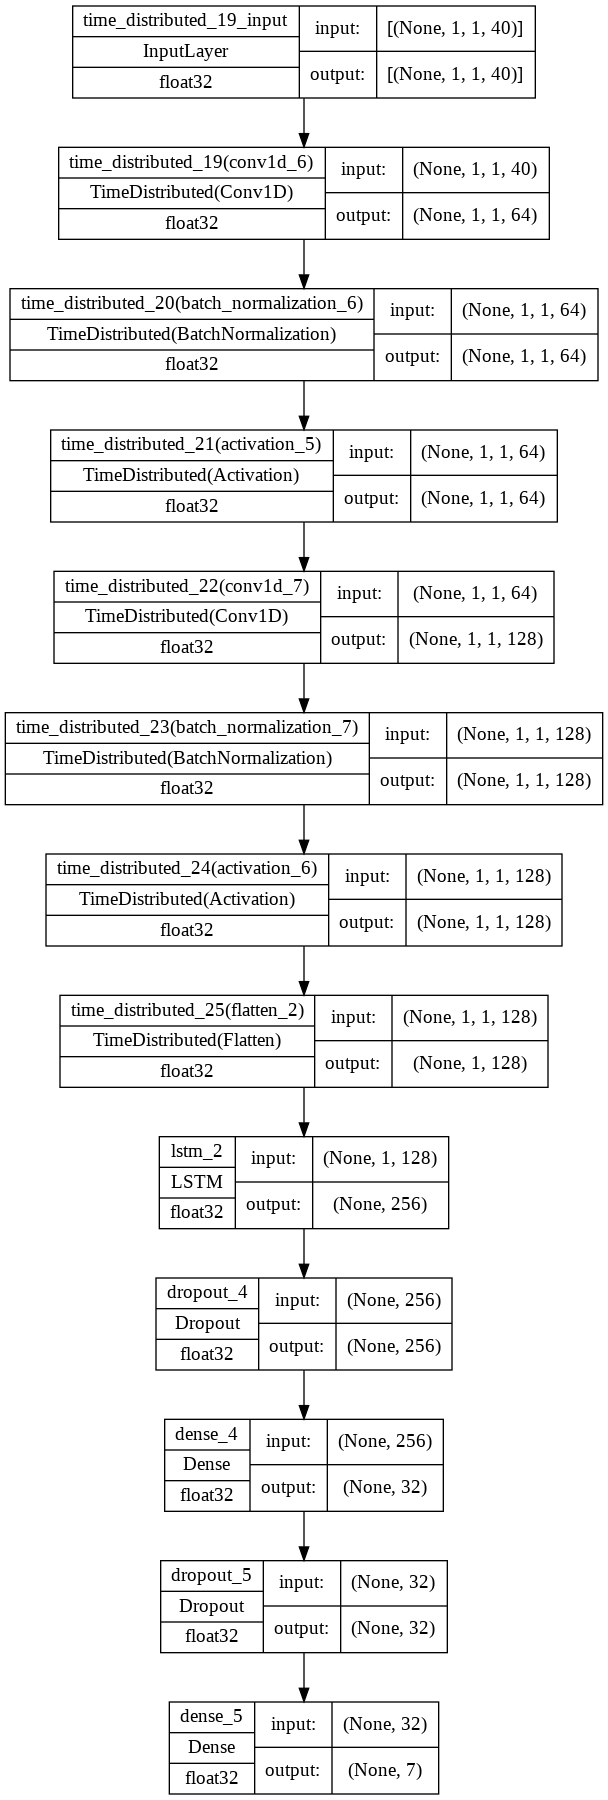

In [ ]:
keras.utils.plot_model(model, show_dtype=True, 
                       show_layer_names=True, show_shapes=True,  
                       to_file='model.png')

In [ ]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [ ]:
## Training my model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/cnn_lstm_500_paper.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

history = model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
115/116 [============================>.] - ETA: 0s - loss: 1.3963 - accuracy: 0.4707
Epoch 1: val_loss improved from inf to 1.45835, saving model to saved_models/cnn_lstm_500_paper.hdf5
116/116 [==============================] - 5s 20ms/step - loss: 1.3938 - accuracy: 0.4714 - val_loss: 1.4584 - val_accuracy: 0.4009
Epoch 2/100
116/116 [==============================] - ETA: 0s - loss: 0.9110 - accuracy: 0.6695
Epoch 2: val_loss improved from 1.45835 to 0.91539, saving model to saved_models/cnn_lstm_500_paper.hdf5
116/116 [==============================] - 1s 11ms/step - loss: 0.9110 - accuracy: 0.6695 - val_loss: 0.9154 - val_accuracy: 0.6756
Epoch 3/100
114/116 [============================>.] - ETA: 0s - loss: 0.7793 - accuracy: 0.7116
Epoch 3: val_loss improved from 0.91539 to 0.74690, saving model to saved_models/cnn_lstm_500_paper.hdf5
116/116 [==============================] - 1s 12ms/step - loss: 0.7779 - accuracy: 0.7120 - val_loss: 0.7469 - val_accuracy: 0.6821
Ep

In [ ]:
loss, acc = model.evaluate(X_test,y_test)
print("Model Accuracy: {:5.2f}%".format(100*acc))
print("Model Loss: {:5.2f}%".format(loss))

29/29 [==============================] - 0s 4ms/step - loss: 0.6334 - accuracy: 0.8567
Model Accuracy: 85.67%
Model Loss:  0.63%


In [ ]:
print(model.evaluate(X_train,y_train))

116/116 [==============================] - 0s 4ms/step - loss: 0.1017 - accuracy: 0.9604
[0.10173500329256058, 0.9603987336158752]


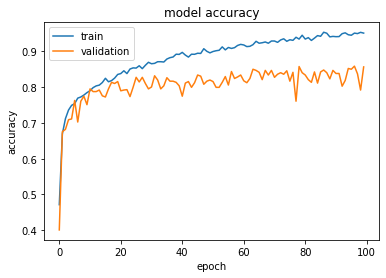

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

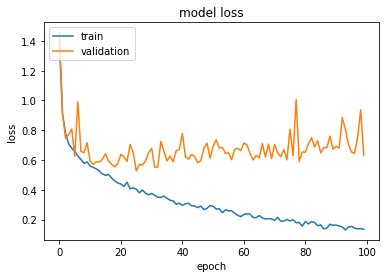

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
loss = history.history['loss']
accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

model_results = pd.DataFrame()
model_results['epochs'] = range(1,12)
model_results['loss'] = loss
model_results['accuracy'] = accuracy
model_results['val_loss'] = val_loss
model_results['val_accuracy'] = val_accuracy

In [ ]:
model_results

,epochs,loss,accuracy,val_loss,val_accuracy
0,1,3.396842,0.184806,1.799520,0.399784
1,2,1.602592,0.357220,1.231445,0.515086
2,3,1.300895,0.498384,1.058403,0.661638
3,4,1.145158,0.561422,0.864152,0.699353
4,5,1.053775,0.594558,0.815788,0.697198
5,6,0.971047,0.623384,0.764726,0.721983
6,7,0.940529,0.642780,0.745523,0.718750
7,8,0.915344,0.653825,0.734519,0.747845
8,9,0.882983,0.665679,0.710636,0.745690
9,10,0.862336,0.677263,0.683306,0.746767


In [ ]:
X_test[1]

array([-375.85068  ,   86.35763  ,   21.226683 ,   45.644417 ,
         -8.248565 ,    4.1287   ,  -10.461711 ,   -5.7135344,
         -5.52071  ,   -5.5966673,  -12.4093895,    7.144957 ,
        -14.895025 ,   12.311402 ,  -10.67461  ,    1.0261024,
         -2.1982286,   -2.3116531,  -11.516636 ,   -4.127701 ,
         -7.912048 ,   -4.475407 ,   -1.9440111,    6.2645283,
          1.1150794,    5.031153 ,   -1.2491494,   -3.7283168,
         -3.8071969,   -0.8560266,    4.8278956,   10.012675 ,
          6.9030924,    2.5040138,    1.7965624,    3.612148 ,
          5.591348 ,    7.4673133,   10.107303 ,    7.6095343],
      dtype=float32)

In [ ]:
y_test[1]

array([0., 0., 0., 0., 0., 1., 0.], dtype=float32)

29/29 [==============================] - 1s 4ms/step


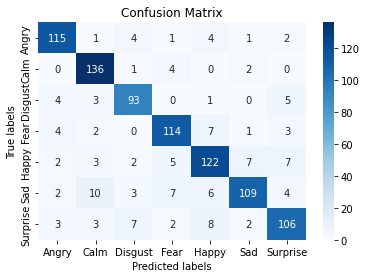

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred=model.predict(X_test) 
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)
matrix = confusion_matrix(y_test,y_pred)

ax= plt.subplot()
sns.heatmap(matrix, linecolor='white', cmap='Blues', annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Angry','Calm','Disgust','Fear','Happy','Sad','Surprise'])
ax.yaxis.set_ticklabels(['Angry','Calm','Disgust','Fear','Happy','Sad','Surprise']);

In [ ]:
from sklearn.metrics import f1_score
print(f1_score(y_test, y_pred, average='macro'))

0.8564002738711883


In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
y_test_inverse = labelencoder.inverse_transform(y_test)
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()
df['Labels'] = y_test_inverse.flatten()
df.tail(11)

,Predicted Labels,Actual Labels,Labels
917,1,1,Calm
918,6,6,Surprise
919,5,5,Sad
920,1,5,Sad
921,4,4,Happy
922,3,3,Fear
923,0,0,Angry
924,1,6,Surprise
925,5,5,Sad
926,5,5,Sad


In [ ]:
print(classification_report(y_test, y_pred,target_names=['Angry','Calm','Disgust','Fear','Happy','Sad','Surprise']))

              precision    recall  f1-score   support

       Angry       0.88      0.90      0.89       128
        Calm       0.86      0.95      0.90       143
     Disgust       0.85      0.88      0.86       106
        Fear       0.86      0.87      0.86       131
       Happy       0.82      0.82      0.82       148
         Sad       0.89      0.77      0.83       141
    Surprise       0.83      0.81      0.82       131

    accuracy                           0.86       928
   macro avg       0.86      0.86      0.86       928
weighted avg       0.86      0.86      0.86       928



In [ ]:
model.save('saved_model/cnn_lstm_paper_100') 

In [2]:
from keras.models import load_model
model = load_model('/content/cnn_lstm_100_paper.hdf5',compile=True)

In [3]:
def predict_emotion(audio_path):
  audio, sample_rate = librosa.load(audio_path, res_type='kaiser_fast') 
  mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
  input_val = np.mean(mfccs_features.T,axis=0)
  X = np.array(input_val.tolist())
  X = np.expand_dims(X, axis=0)

  X = np.expand_dims(X, axis=2)
  X = np.swapaxes(X, 1, 2)
  X = np.expand_dims(X, axis=2)


  #pass it throught the model
  pred = []
  pred_proba = []
  y_pred=model.predict(X)
  max_emo = np.argmax(y_pred)

  pred.append(max_emo)
  di = {0:'Angry',1: 'Calm',2: 'Disgust',3: 'Fear',4:'Happy',5:'Sad',6:'Surprise'}
  emo =[di.get(a) if di.get(a) else a for a in pred]
  #predict!
  print(emo)

In [ ]:
predict_emotion('/content/S01_achievement_peak_01.wav')

1/1 [==============================] - 3s 3s/step
['Happy']


In [ ]:
predict_emotion('/content/S07_anger_strong_02.wav')

1/1 [==============================] - 0s 39ms/step
['Angry']


In [ ]:
predict_emotion('/content/S04_fear_strong_09.wav')

1/1 [==============================] - 0s 35ms/step
['Fear']


In [ ]:
import IPython.display as idisp
from IPython.display import Audio

display(idisp.Audio('/content/S07_anger_strong_02.wav', autoplay=True))